# Lesson 11: Multimodal

This notebook demonstrates how to build multimodal AI systems that can process and understand multimodal data such text, images and documents using Google's Gemini models.

We will use the `google-genai` library to interact with Google's Gemini models.

**Learning Objectives:**

1. **Process multimodal content**: Learn to handle images and PDFs in different formats (bytes, base64, URLs) with Gemini models
2. **Implement object detection**: Use multimodal LLMs for visual analysis and structured output generation
3. **Build multimodal RAG systems**: Create and index embeddings for images, documents and text to enable semantic search across multimodal content
4. **Develop multimodal AI agents**: Construct ReAct agents that can search through and reason about multimodal information

## 1. Setup

First, we define some standard Magic Python commands to autoreload Python packages whenever they change:

In [1]:
%load_ext autoreload
%autoreload 2

### Set Up Python Environment

To set up your Python virtual environment using `uv` and load it into the Notebook, follow the step-by-step instructions from the `Course Admin` lesson from the beginning of the course.

**TL/DR:** Be sure the correct kernel pointing to your `uv` virtual environment is selected.

### Configure Gemini API

To configure the Gemini API, follow the step-by-step instructions from the `Course Admin` lesson.

But here is a quick check on what you need to run this Notebook:

1.  Get your key from [Google AI Studio](https://aistudio.google.com/app/apikey).
2.  From the root of your project, run: `cp .env.example .env` 
3.  Within the `.env` file, fill in the `GOOGLE_API_KEY` variable:

Now, the code below will load the key from the `.env` file:

In [2]:
from lessons.utils import env

env.load(required_env_vars=["GOOGLE_API_KEY"])

Trying to load environment variables from `/Users/pauliusztin/Documents/01_projects/TAI/course-ai-agents/.env`
Environment variables loaded successfully.


### Import Key Packages

In [3]:
import base64
import io
from pathlib import Path
from typing import Literal

from google import genai
from google.genai import types
from IPython.display import Image as IPythonImage
from PIL import Image as PILImage

from lessons.utils import pretty_print

### Initialize the Gemini Client

In [4]:
client = genai.Client()

### Define Constants

We will use the `gemini-2.5-flash` model, which is fast and cost-effective:

In [5]:
MODEL_ID = "gemini-2.5-flash"

## 2. Applying multimodal LLMs to images and PDFs

There are three core ways we can process images and PDFs with multimodal LLMs:
1. As raw bytes
2. As base64 encoded strings
3. As URLs

We will first look into how we can process images and then PDFs.

Now, let's look at our test image:


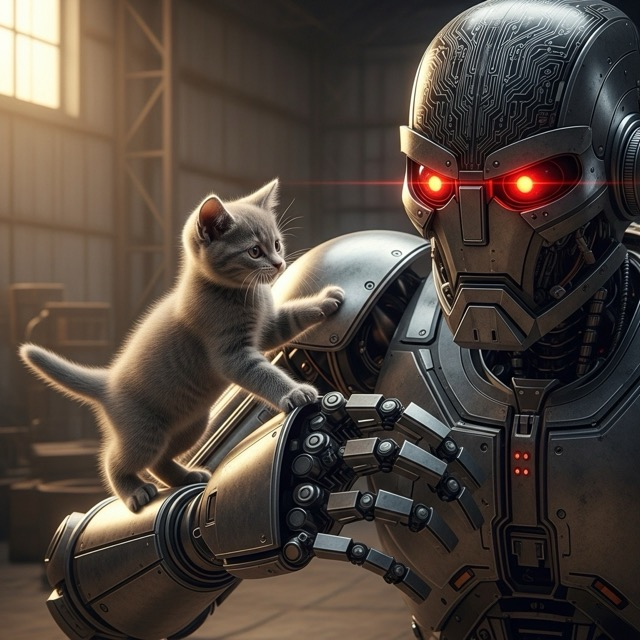

In [6]:
def display_image(image_path: Path) -> None:
    """
    Display an image from a file path in the notebook.

    Args:
        image_path: Path to the image file to display

    Returns:
        None
    """

    image = IPythonImage(filename=image_path, width=400)
    display(image)


display_image(Path("images") / "image_1.jpeg")

### 2.1 As raw bytes

In [7]:
def load_image_as_bytes(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> bytes | tuple[bytes, tuple[int, int]]:
    """
    Load an image from file path and convert it to bytes with optional resizing.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: If True, returns both bytes and image size tuple. Defaults to False

    Returns:
        bytes: Image data as bytes, or tuple of (bytes, (width, height)) if return_size is True
    """

    image = PILImage.open(image_path)
    if image.width > max_width:
        ratio = max_width / image.width
        new_size = (max_width, int(image.height * ratio))
        image = image.resize(new_size)

    byte_stream = io.BytesIO()
    image.save(byte_stream, format=format)

    if return_size:
        return byte_stream.getvalue(), image.size

    return byte_stream.getvalue()

Load image:

In [8]:
image_bytes = load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP")
pretty_print.wrapped([f"Bytes `{image_bytes[:30]}...`", f"Size: {len(image_bytes)} bytes"], title="Image as Bytes")

------------------------------------------ Image as Bytes ------------------------------------------
  Bytes `b'RIFF`\xad\x00\x00WEBPVP8 T\xad\x00\x00P\xec\x02\x9d\x01*X\x02X\x02'...`
----------------------------------------------------------------------------------------------------
  Size: 44392 bytes
----------------------------------------------------------------------------------------------------


Compute captions:

In [9]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        "Tell me what is in this image in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Image 1 Caption")


----------------------------------------- Image 1 Caption -----------------------------------------
  This image presents a striking contrast between a large, imposing humanoid robot and a small, delicate kitten within an industrial setting. The robot is crafted from dark, intricate metallic plates, featuring a head adorned with circuit-like patterns and intensely glowing red eyes that convey a powerful, almost menacing presence. Perched playfully on the robot's heavily armored right arm, with its front paws resting gently on the shoulder, is a fluffy grey tabby kitten, looking out with an expression of curious innocence. The background reveals a sparse workshop or factory environment with metallic structures and a soft, diffused light source from the upper left, creating a scene that beautifully juxtaposes advanced technology with the simple charm of nature.
----------------------------------------------------------------------------------------------------


Using the same approach, we can easily pass multiple images simultaneously. For example, the previous one plus the one below, and compare them:

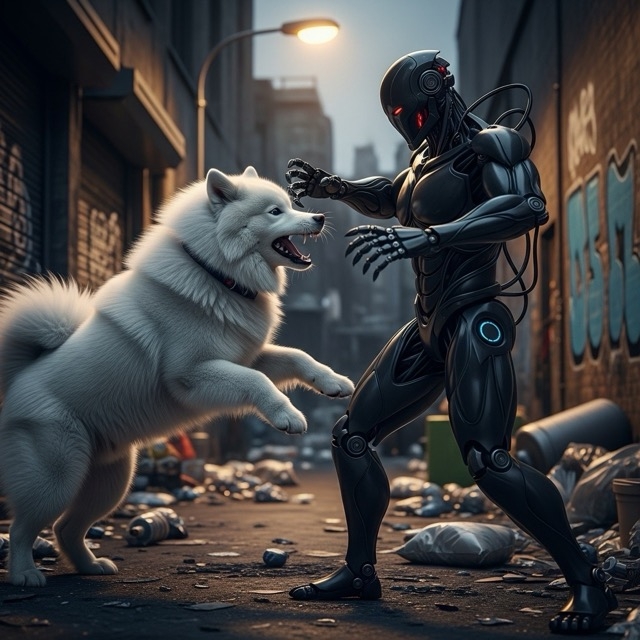

In [10]:
display_image(Path("images") / "image_2.jpeg")

In [11]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_1.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_2.jpeg", format="WEBP"),
            mime_type="image/webp",
        ),
        "What's the difference between these two images? Describe it in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Differences between images")


------------------------------------ Differences between images ------------------------------------
  The primary difference between the two images is the nature of the interaction and the overall mood. The first image depicts a small, grey kitten playfully climbing on the arm of a large, imposing robot in what appears to be an industrial setting, suggesting curiosity, gentle engagement, or even budding companionship. In stark contrast, the second image portrays a large, fluffy white dog and a sleek, black robot locked in aggressive, confrontational stances in a dilapidated urban alleyway, conveying a clear sense of hostility, imminent conflict, and tension rather than interaction.
----------------------------------------------------------------------------------------------------


### 2.2 As base64 encoded strings

Now, let's load the same image as base64:

In [12]:
from typing import cast


def load_image_as_base64(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> str:
    """
    Load an image and convert it to base64 encoded string.

    Args:
        image_path: Path to the image file to load
        format: Output image format (WEBP, JPEG, or PNG). Defaults to "WEBP"
        max_width: Maximum width for resizing. If image width exceeds this, it will be resized proportionally. Defaults to 600
        return_size: Parameter passed to load_image_as_bytes function. Defaults to False

    Returns:
        str: Base64 encoded string representation of the image
    """

    image_bytes = load_image_as_bytes(image_path=image_path, format=format, max_width=max_width, return_size=False)

    return base64.b64encode(cast(bytes, image_bytes)).decode("utf-8")

In [13]:
image_base64 = load_image_as_base64(image_path=Path("images") / "image_1.jpeg", format="WEBP")
pretty_print.wrapped(
    [f"Base64: {image_base64[:100]}...`", f"Size: {len(image_base64)} characters"], title="Image as Base64"
)

----------------------------------------- Image as Base64 -----------------------------------------
  Base64: UklGRmCtAABXRUJQVlA4IFStAABQ7AKdASpYAlgCPm0ylEekIqInJnQ7gOANiWdtk7FnEo2gDknjPixW9SNSb5P7IbBNhLn87Vtp...`
----------------------------------------------------------------------------------------------------
  Size: 59192 characters
----------------------------------------------------------------------------------------------------


On average base64 format is 33% larger than raw bytes. As we can see in this use case as well:

In [14]:
print(f"Image as Base64 is {(len(image_base64) - len(image_bytes)) / len(image_bytes) * 100:.2f}% larger than as bytes")

Image as Base64 is 33.34% larger than as bytes


Now, let's recompute the image caption using this method:

In [15]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=image_base64, mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
response.text

'The image presents a striking juxtaposition of a powerful, metallic robot and a small, curious kitten. The robot, dominating the right side of the frame, features a dark, intricately detailed head resembling circuit board patterns, with intense, glowing red eyes that pierce forward. Its massive, articulated arm is extended, and a fluffy grey tabby kitten is playfully perched on its forearm and shoulder, looking towards the robot with a raised paw as if exploring or batting it. The background suggests an industrial or workshop environment, with metallic structures and diffuse light from a window on the left, highlighting the unexpected encounter between advanced technology and innocent nature.'

### 2.3 As public URLs

Using Gemini `url_context` out-of-the-box tool, we can automatically visit and parse webpages, PDFs, and images from the open internet. You only have to provide the direct URL in the prompt and configure the `url_context` tool. This makes it a no-brainer to parse multiple data formats when available online:

In [16]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Based on the provided paper as a PDF, tell me how ReAct works: https://arxiv.org/pdf/2210.03629",
    config=types.GenerateContentConfig(tools=[{"url_context": {}}]),
)
pretty_print.wrapped(response.text, title="How ReAct works")

----------------------------------------- How ReAct works -----------------------------------------
  
The ReAct (Reasoning and Acting) paradigm is a method that combines verbal reasoning traces with task-specific actions in an interleaved manner within large language models (LLMs). This approach allows for greater synergy between reasoning and acting, enabling LLMs to perform more dynamic reasoning and interact with external environments.

Here's a breakdown of how ReAct works:
*   **Interleaved Reasoning and Acting:** ReAct prompts LLMs to generate both "thoughts" (verbal reasoning traces) and "actions" related to a task. These are produced in an alternating sequence, mimicking human cognition where inner speech (reasoning) guides actions, and actions provide new information for further reasoning.
*   **Reasoning to Act:** The reasoning traces help the model to induce, track, and update action plans, as well as handle exceptions. For example, a thought might involve decomposing a tas

### 2.4 As URLs from private data lakes

At the time of writing this notebook, Gemini works well primarily with GCP Cloud Storage links and not with other buckets such as S3. Buckets are excellent for production use cases, but they complicate our simple demonstration. Therefore, we will show you a mocked example.

The code would look like this, where you have to change the `uri` and ensure the LLM has the right permissions to your GCS bucket:
```python
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_uri(uri="gs://gemini-images/image_1.jpeg", mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
```

### 2.5 Object detection with LLMs

As a more exciting example, let's do object detection with multimodal LLMs.

First, let's define the output Pydantic models:

In [17]:
from pydantic import BaseModel, Field


class BoundingBox(BaseModel):
    ymin: float
    xmin: float
    ymax: float
    xmax: float
    label: str = Field(
        default="The category of the object found within the bounding box. For example: cat, dog, diagram, robot."
    )


class Detections(BaseModel):
    bounding_boxes: list[BoundingBox]

Then the prompt and image:

In [51]:
prompt = """
Detect all of the prominent items in the image. 
The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000.
Also, output the label of the object found within the bounding box.
"""

image_bytes, image_size = load_image_as_bytes(
    image_path=Path("images") / "image_1.jpeg", format="WEBP", return_size=True
)

Now, let's call the LLM:

In [52]:
config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=Detections,
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        prompt,
    ],
    config=config,
)

detections = cast(Detections, response.parsed)
pretty_print.wrapped([f"Image size: {image_size}", *detections.bounding_boxes], title="Detections")

-------------------------------------------- Detections --------------------------------------------
  Image size: (600, 600)
----------------------------------------------------------------------------------------------------
  ymin=2.0 xmin=517.0 ymax=997.0 xmax=1000.0 label='robot'
----------------------------------------------------------------------------------------------------
  ymin=272.0 xmin=28.0 ymax=801.0 xmax=535.0 label='kitten'
----------------------------------------------------------------------------------------------------


Let's also visualize the bounding boxes: 

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def visualize_detections(detections: Detections, image_path: Path) -> None:
    """
    Visualize detected bounding boxes on an image with red rectangles and labels.

    Args:
        detections: Detections object containing bounding boxes in [ymin, xmin, ymax, xmax] format normalized to 0-1000
        image_path: Path to the image file to visualize

    Returns:
        None: Displays the image with bounding boxes in the notebook
    """

    # Clear any existing plots to prevent overlapping
    plt.clf()

    image = PILImage.open(image_path)
    image_array = np.array(image)
    img_height, img_width = image_array.shape[:2]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image_array)

    for bbox in detections.bounding_boxes:
        # Convert normalized coordinates (0-1000) to pixel coordinates
        xmin = (bbox.xmin / 1000) * img_width
        ymin = (bbox.ymin / 1000) * img_height
        xmax = (bbox.xmax / 1000) * img_width
        ymax = (bbox.ymax / 1000) * img_height

        # Calculate box dimensions (matplotlib uses bottom-left corner + width/height)
        width = xmax - xmin
        height = ymax - ymin

        # Create rectangle patch (x, y is bottom-left corner)
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=3, edgecolor="red", facecolor="none")

        # Add rectangle to the plot
        ax.add_patch(rect)

        # Add label text (positioned at top-left of bounding box)
        ax.text(
            xmin,
            ymin + 5,  # Slightly above the box
            bbox.label[:15],
            fontsize=12,
            color="red",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Remove axis ticks and labels for cleaner display
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Object Detection Results: {image_path.name}", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

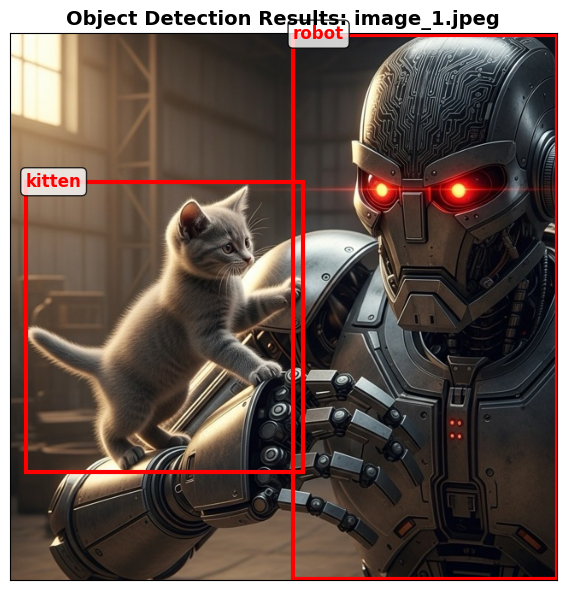

In [53]:
visualize_detections(detections, Path("images") / "image_1.jpeg")

### 2.6 Working with PDFs

Ultimately, let's see how we can work with PDFs. We will use the legendary `Attention Is All You Need` Paper as an example. 

To display it, we extracted the first 3 pages of the PDF as images. For example, this is how the page looks:


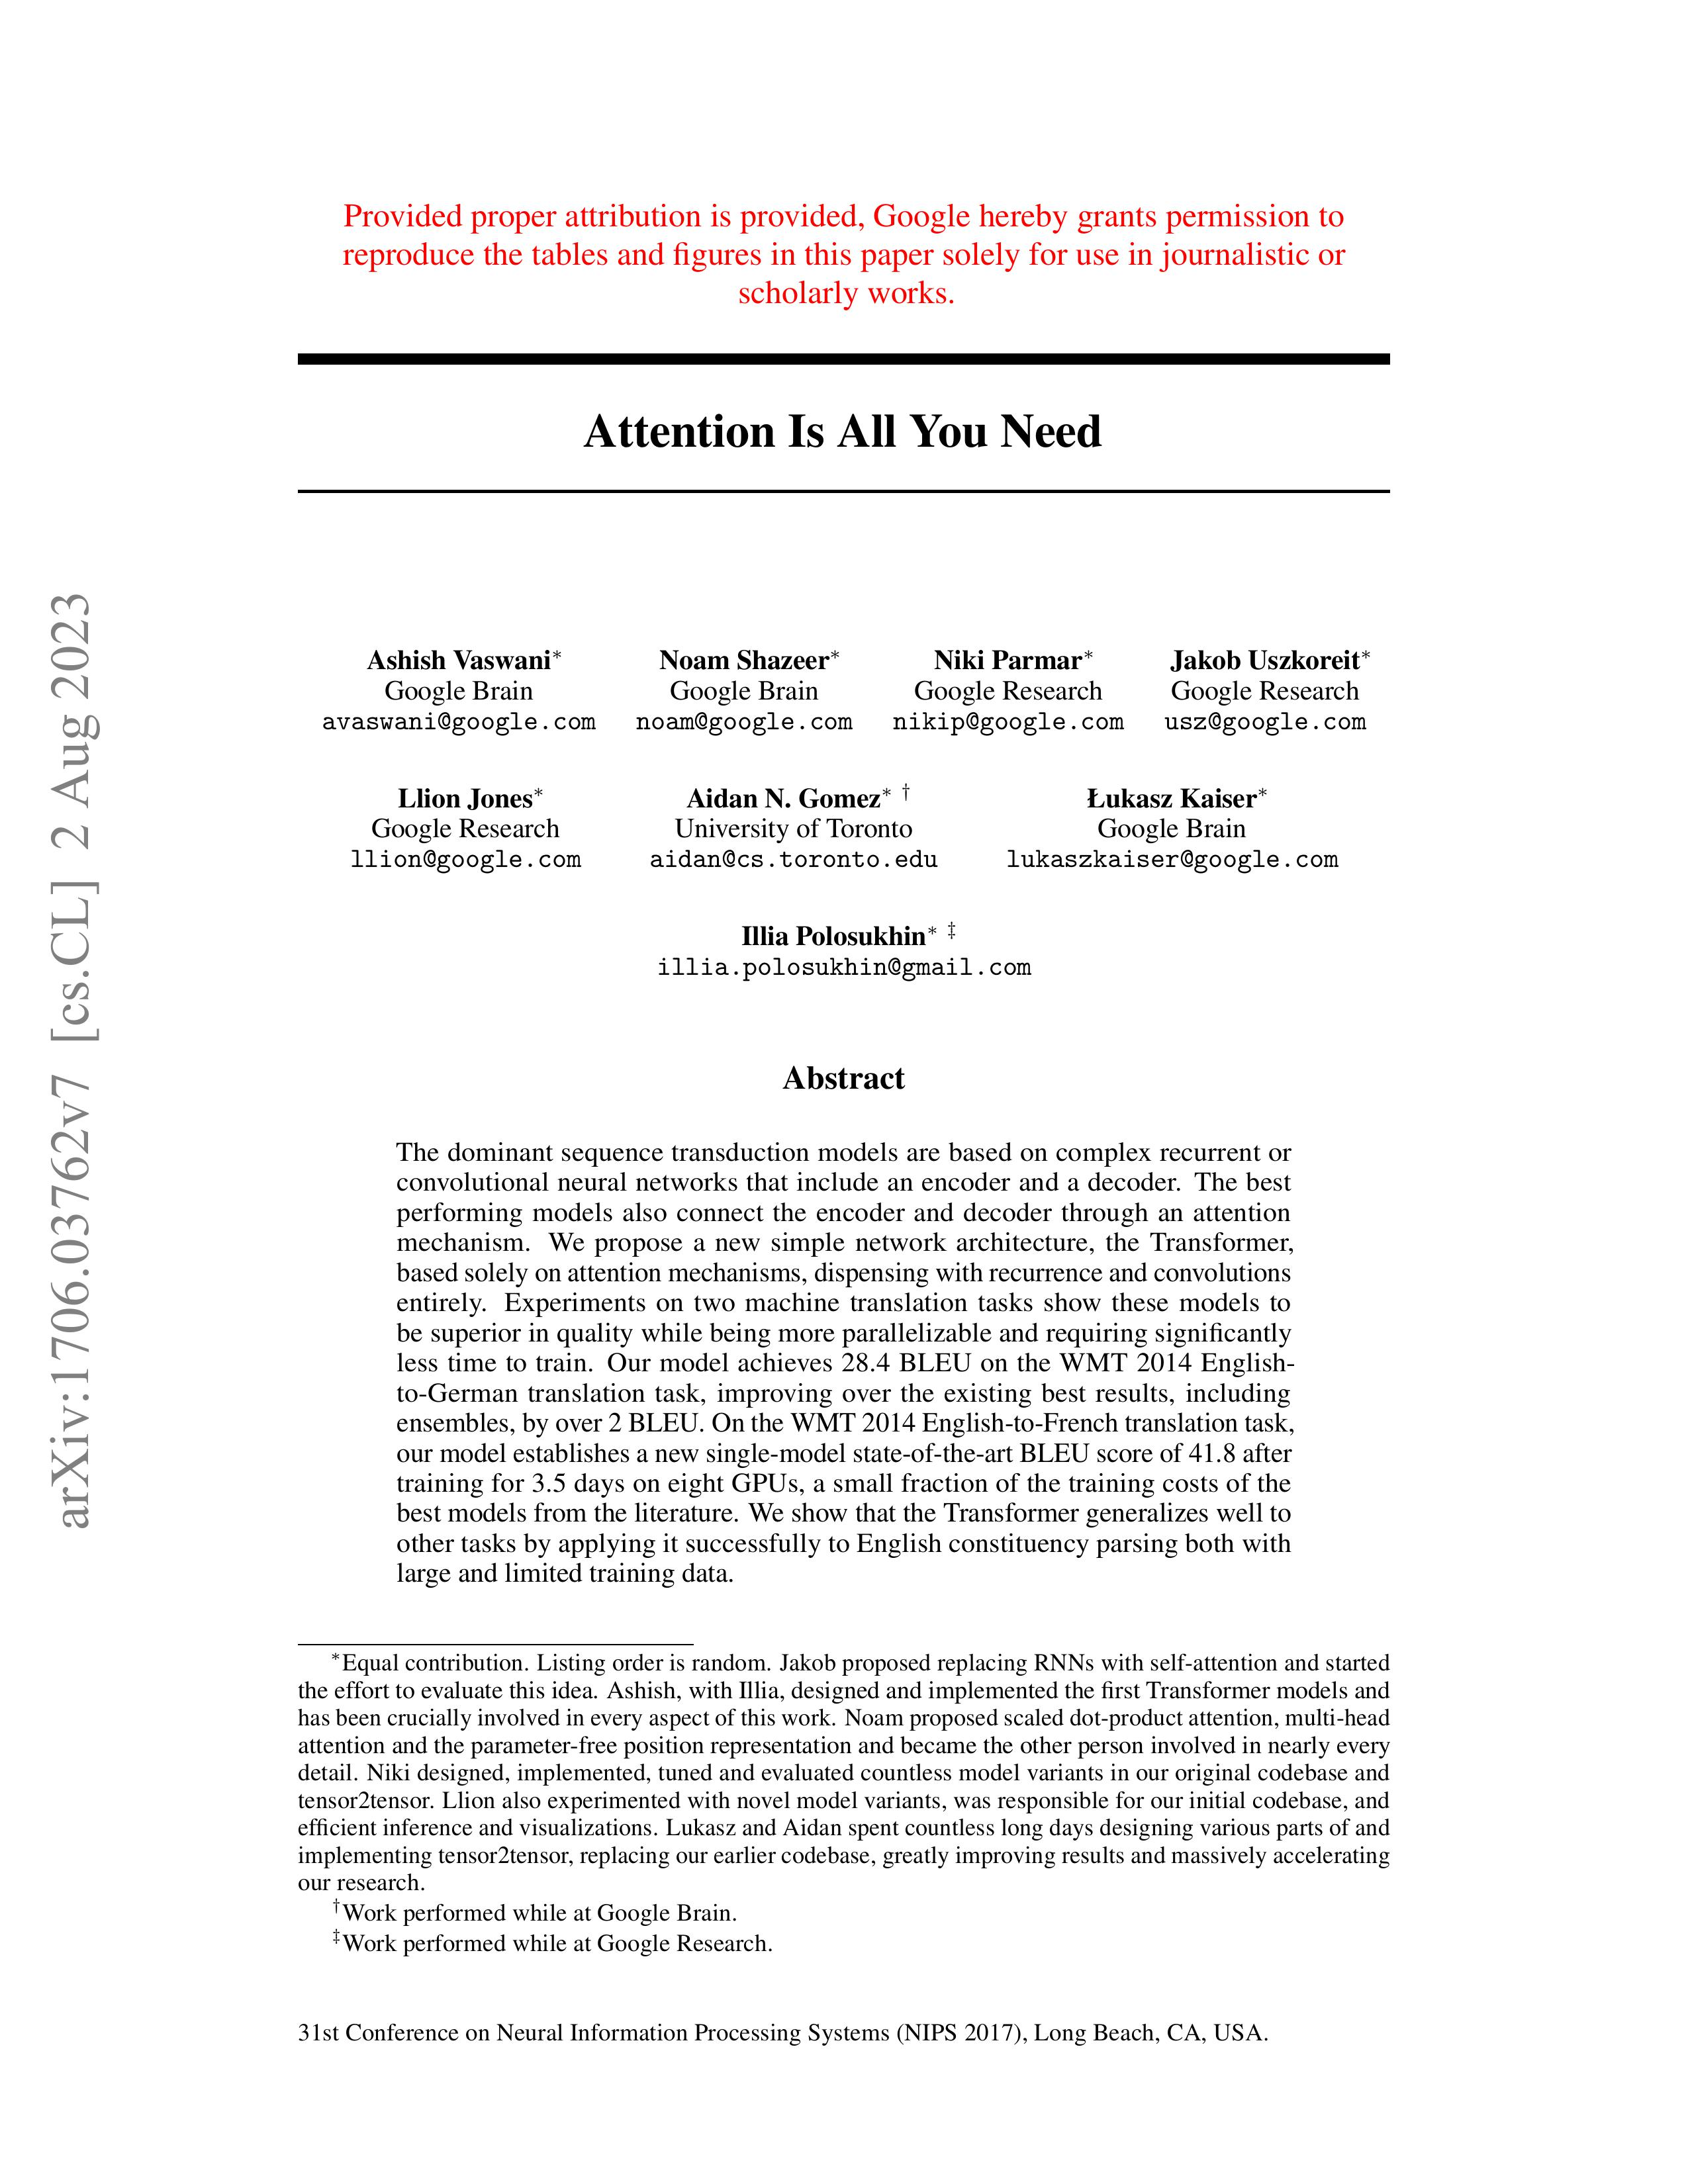

In [22]:
display_image(Path("images") / "attention_is_all_you_need_0.jpeg")

We can treat PDFs similarly to images. Therefore, we can pass PDFs as bytes:

In [23]:
pdf_bytes = (Path("pdfs") / "attention_is_all_you_need_paper.pdf").read_bytes()
pretty_print.wrapped(f"Bytes: {pdf_bytes[:40]}...", title="PDF bytes")

-------------------------------------------- PDF bytes --------------------------------------------
  Bytes: b'%PDF-1.7\n%\xe2\xe3\xcf\xd3\n24 0 obj\n<<\n/Filter /Flat'...
----------------------------------------------------------------------------------------------------


Call the LLM:

In [24]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=pdf_bytes, mime_type="application/pdf"),
        "What is this document about? Provide a brief summary of the main topics.",
    ],
)
pretty_print.wrapped(response.text, title="PDF Summary (as bytes)")

-------------------------------------- PDF Summary (as bytes) --------------------------------------
  This document introduces the **Transformer**, a novel neural network architecture for **sequence transduction** (e.g., machine translation) that relies **solely on attention mechanisms**, entirely **dispensing with recurrent and convolutional layers**.

The main topics covered include:

1.  **The Transformer Architecture:** A detailed description of its encoder-decoder structure, utilizing stacked multi-head self-attention and position-wise fully connected layers.
2.  **Attention Mechanisms:** Explanation of scaled dot-product attention, multi-head attention, and their application within the encoder and decoder.
3.  **Positional Encoding:** How sequence order information is integrated into the model, given the absence of recurrence or convolution.
4.  **Advantages of Self-Attention:** A comparison highlighting self-attention's benefits in computational complexity, parallelization, and

Alternatively, as base64 encoded strings:

In [25]:
def load_pdf_as_base64(pdf_path: Path) -> str:
    """
    Load a PDF file and convert it to base64 encoded string.

    Args:
        pdf_path: Path to the PDF file to load

    Returns:
        str: Base64 encoded string representation of the PDF
    """

    with open(pdf_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

Load the PDF:

In [26]:
pdf_base64 = load_pdf_as_base64(pdf_path=Path("pdfs") / "attention_is_all_you_need_paper.pdf")
pretty_print.wrapped(f"Base64: {pdf_base64[:40]}...", title="PDF as Base64")

------------------------------------------ PDF as Base64 ------------------------------------------
  Base64: JVBERi0xLjcKJeLjz9MKMjQgMCBvYmoKPDwKL0Zp...
----------------------------------------------------------------------------------------------------


Call the LLM:

In [27]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "What is this document about? Provide a brief summary of the main topics.",
        types.Part.from_bytes(data=pdf_base64, mime_type="application/pdf"),
    ],
)

pretty_print.wrapped(response.text, title="PDF Summary (as base64)")

------------------------------------- PDF Summary (as base64) -------------------------------------
  This document introduces **The Transformer**, a novel neural network architecture designed for sequence transduction tasks, such as machine translation.

Here's a brief summary of the main topics:

1.  **Introduction of the Transformer Architecture:** The paper proposes a new model that completely dispenses with recurrent neural networks (RNNs) and convolutional neural networks (CNNs), relying entirely on **attention mechanisms**.
2.  **Self-Attention and Multi-Head Attention:** The core of the Transformer is its self-attention mechanism, specifically a "Scaled Dot-Product Attention" which is further enhanced by "Multi-Head Attention" to allow the model to jointly attend to information from different representation subspaces.
3.  **Encoder-Decoder Structure with Positional Encodings:** The Transformer maintains an encoder-decoder structure, with each stack composed of multiple identica

Now, let's do a more interesting example and detect the diagrams from a page of the transformers paper, such as the one below:

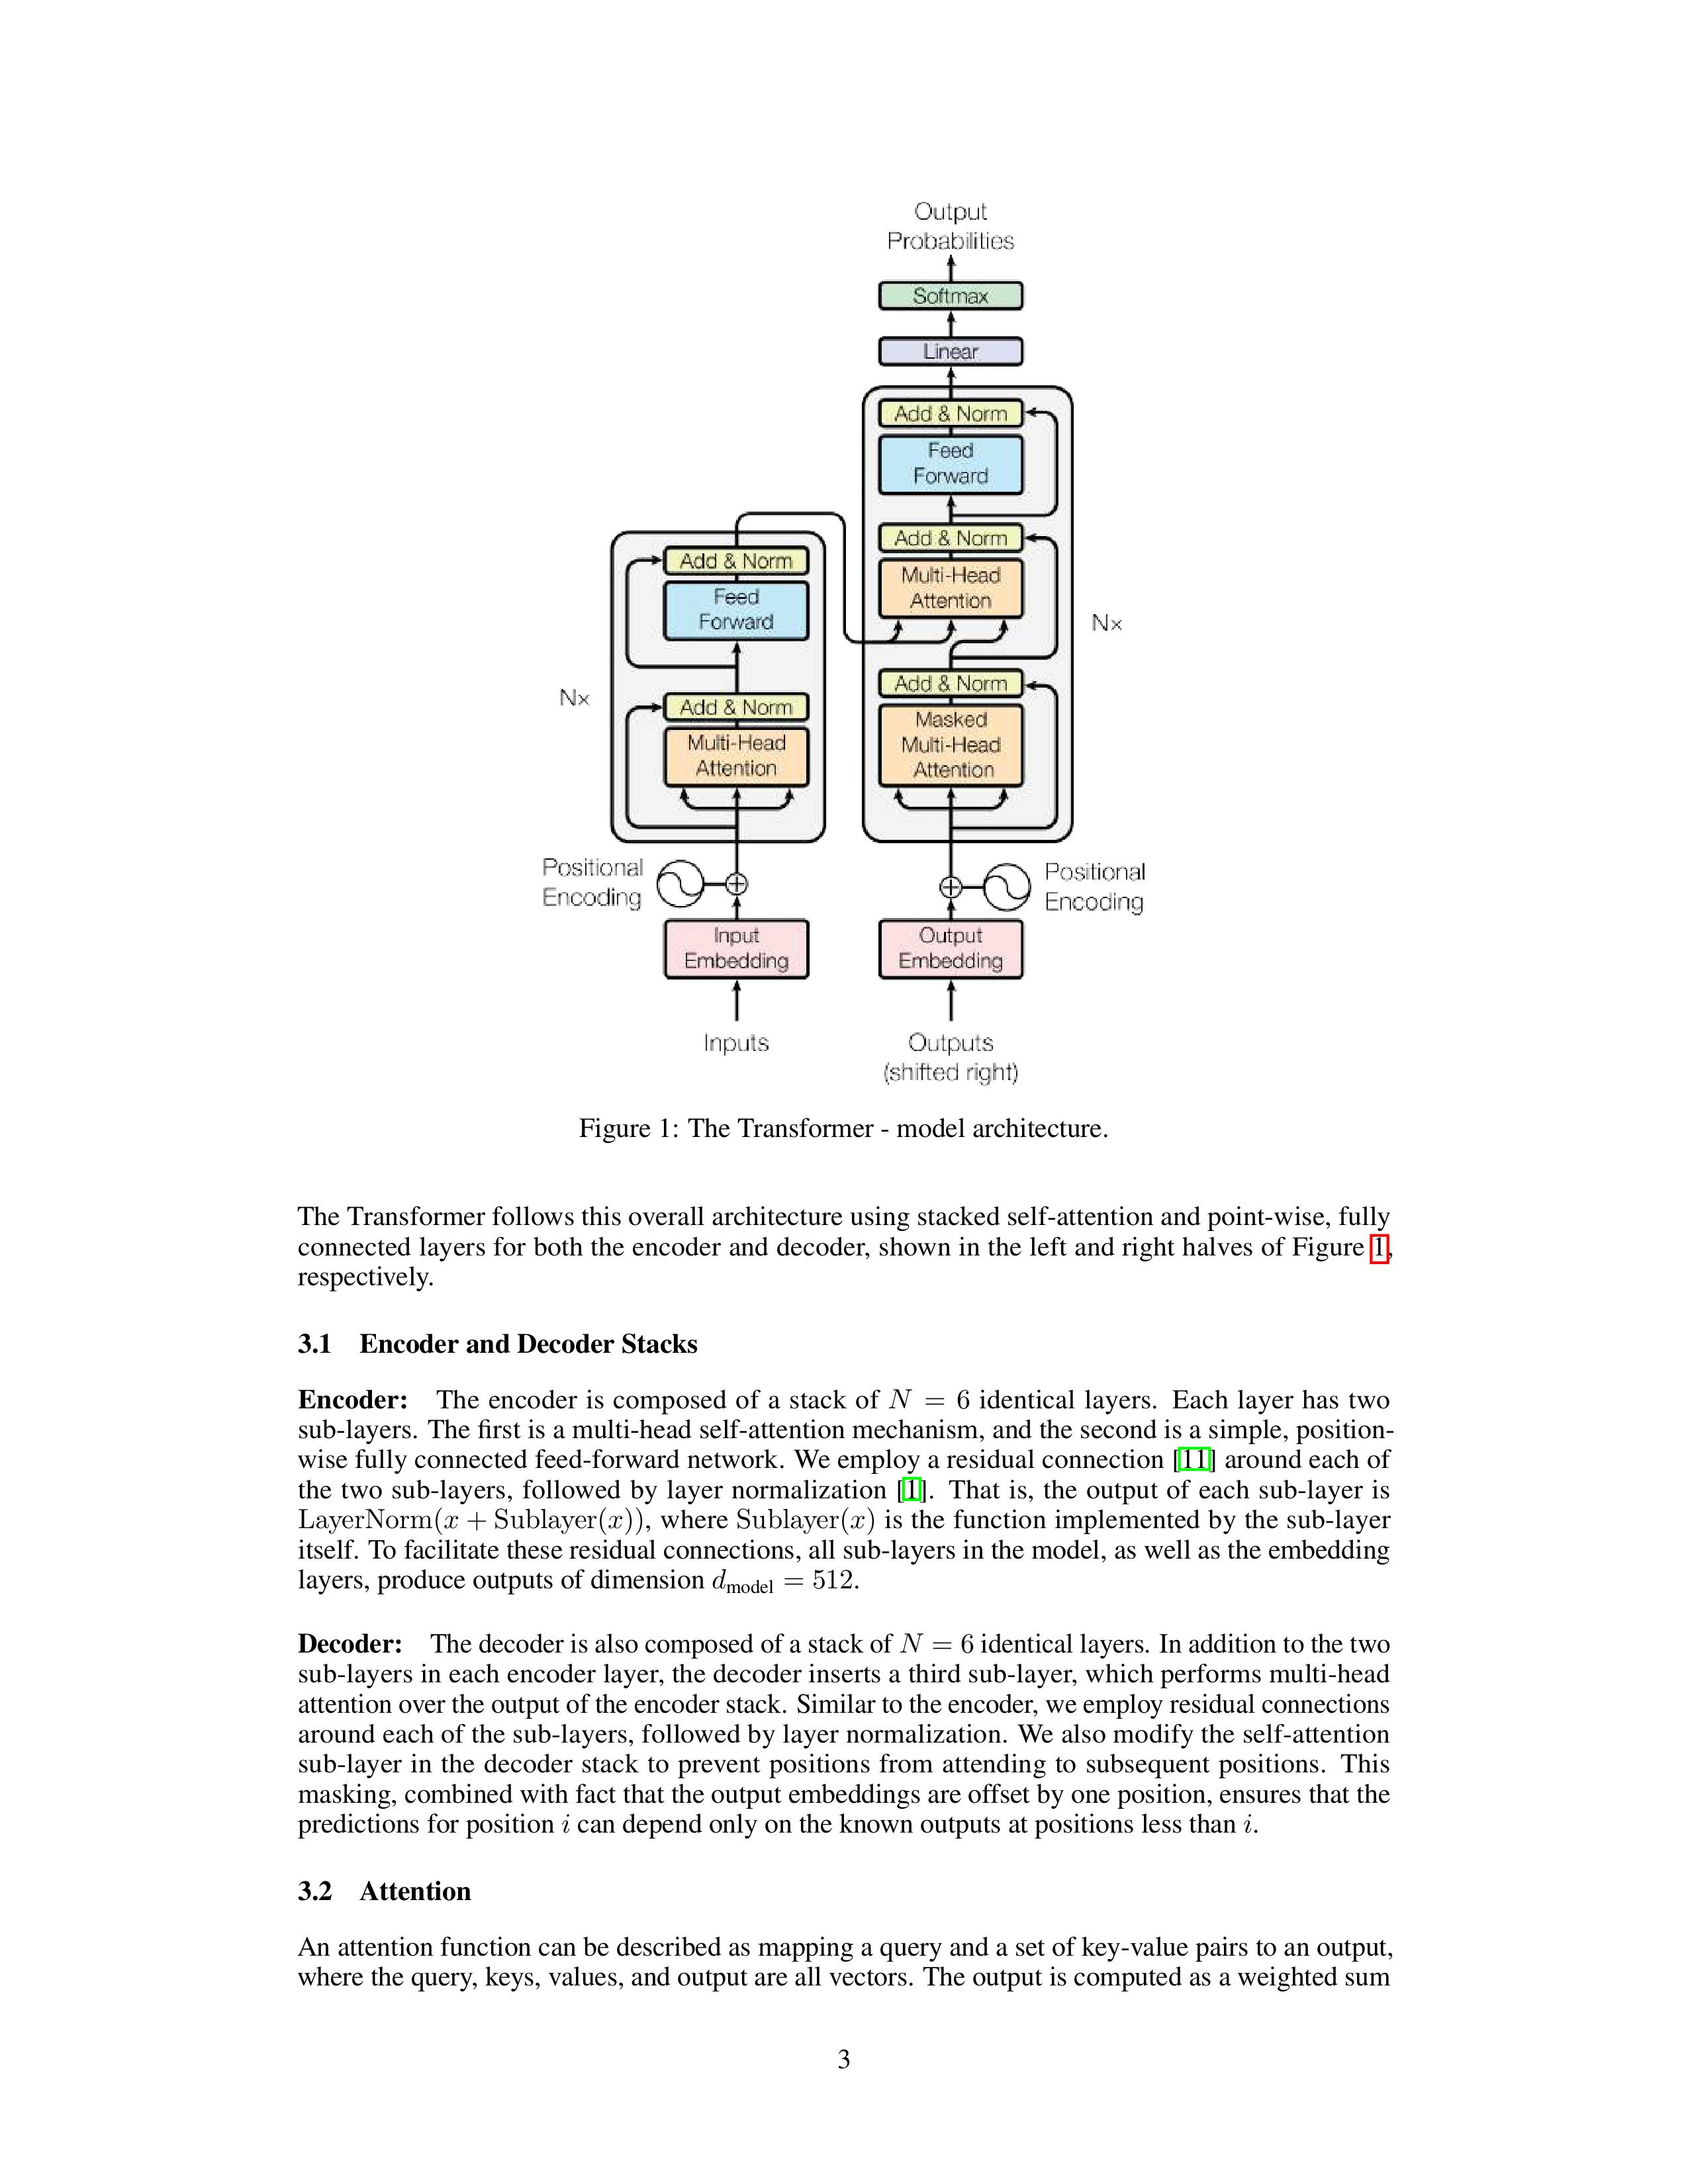

In [28]:
display_image(Path("images") / "attention_is_all_you_need_1.jpeg")

Define the object detection prompt to detect diagrams (similar to how we did for images):

In [54]:
prompt = """
Detect all the diagrams from the provided image as 2d bounding boxes. 
The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000.
Also, output the label of the object found within the bounding box.
"""

image_bytes, image_size = load_image_as_bytes(
    image_path=Path("images") / "attention_is_all_you_need_1.jpeg", format="WEBP", return_size=True
)

Call the LLM:

In [59]:
config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=Detections,
)
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        prompt,
    ],
    config=config,
)
detections = cast(Detections, response.parsed)
pretty_print.wrapped([f"Image size: {image_size}", *detections.bounding_boxes], title="Detections")

-------------------------------------------- Detections --------------------------------------------
  Image size: (600, 776)
----------------------------------------------------------------------------------------------------
  ymin=80.0 xmin=280.0 ymax=470.0 xmax=720.0 label='diagram'
----------------------------------------------------------------------------------------------------


Visualize the detections:

<Figure size 640x480 with 0 Axes>

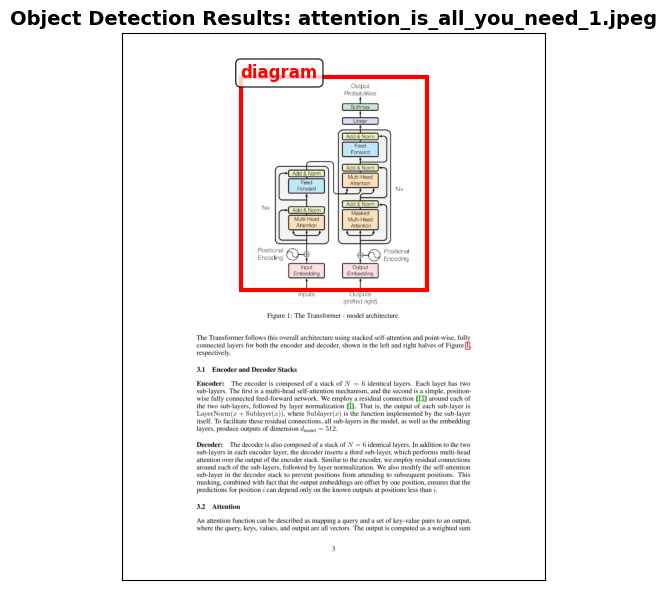

In [60]:
visualize_detections(detections, Path("images") / "attention_is_all_you_need_1.jpeg")

## 3. Implementing multimodal RAG for images, PDFs and text

To bring everything we did in this course together, let's implement a multimodal RAG system that works with text, images, and PDFs.

These are the images and PDF pages (as images) we will index for semantic search:

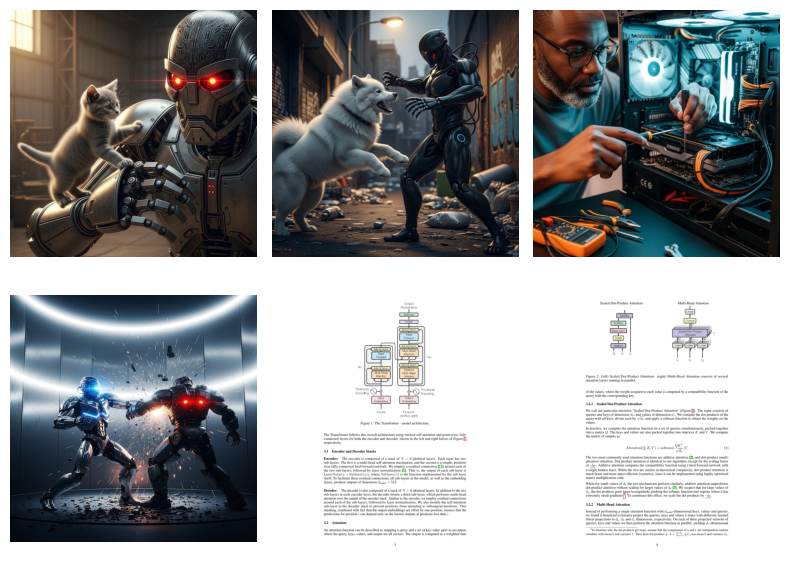

In [32]:
def display_image_grid(image_paths: list[Path], rows: int = 2, cols: int = 2, figsize: tuple = (8, 6)) -> None:
    """
    Display a grid of images.

    Args:
        image_paths: List of paths to images to display
        rows: Number of rows in the grid
        cols: Number of columns in the grid
        figsize: Figure size as (width, height)
    """

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()

    for idx, img_path in enumerate(image_paths[: rows * cols]):
        img = PILImage.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


display_image_grid(
    image_paths=[
        Path("images") / "image_1.jpeg",
        Path("images") / "image_2.jpeg",
        Path("images") / "image_3.jpeg",
        Path("images") / "image_4.jpeg",
        Path("images") / "attention_is_all_you_need_1.jpeg",
        Path("images") / "attention_is_all_you_need_2.jpeg",
    ],
    rows=2,
    cols=3,
)

Now, let's define the core functions.

First, one that creates image descriptions:

In [33]:
from io import BytesIO
from typing import Any

import numpy as np


def generate_image_description(image_bytes: bytes) -> str:
    """
    Generate a detailed description of an image using Gemini Vision model.

    Args:
        image_bytes: Image data as bytes

    Returns:
        str: Generated description of the image
    """

    try:
        # Convert bytes back to PIL Image for vision model
        img = PILImage.open(BytesIO(image_bytes))

        # Use Gemini Vision model to describe the image
        prompt = """
        Describe this image in detail for semantic search purposes. 
        Include objects, scenery, colors, composition, text, and any other visual elements that would help someone find 
        this image through text queries.
        """

        response = client.models.generate_content(
            model=MODEL_ID,
            contents=[prompt, img],
        )

        if response and response.text:
            description = response.text.strip()

            return description
        else:
            print("❌ No description generated from vision model")

            return ""

    except Exception as e:
        print(f"❌ Failed to generate image description: {e}")

        return ""


Another one that creates embedding using `gemini_embedding-001`, based on the given input:

In [34]:
def embed_text_with_gemini(content: str) -> np.ndarray | None:
    """
    Embed text content using Gemini's text embedding model.

    Args:
        content: Text string to embed

    Returns:
        np.ndarray | None: Embedding vector as numpy array or None if failed
    """

    try:
        result = client.models.embed_content(
            model="gemini-embedding-001",  # Gemini's text embedding model
            contents=[content],
        )
        if not result or not result.embeddings:
            print("❌ No embedding data found in response")
            return None

        return np.array(result.embeddings[0].values)

    except Exception as e:
        print(f"❌ Failed to embed text: {e}")
        return None

Let's see how this works:

In [35]:
embedding = embed_text_with_gemini("This is a test")
embedding

array([-0.02252334, -0.00076438,  0.00240217, ..., -0.00574729,
       -0.00052345, -0.00213343], shape=(3072,))

As we can see below, it creates a 3072 embedding from the input text:

In [36]:
embedding.shape

(3072,)

Let's glue these functions and create the vector index out of our test images and PDF pages:

In [37]:
from typing import cast


def create_vector_index(image_paths: list[Path]) -> list[dict]:
    """
    Create embeddings for images by generating descriptions and embedding them.

    This function processes a list of image paths by:
    1. Loading each image as bytes
    2. Generating a text description using Gemini Vision
    3. Creating an embedding of that description using Gemini Embeddings

    Args:
        image_paths (list[Path]): List of paths to image files to process

    Returns:
        list[dict]: List of dictionaries with the following keys:
            - content (bytes): Raw image bytes
            - type (str): Always "image"
            - filename (Path): Original image path
            - description (str): Generated image description
            - embedding (np.ndarray): Vector embedding of the description
    """

    vector_index = []
    for image_path in image_paths:
        image_bytes = cast(bytes, load_image_as_bytes(image_path, format="WEBP", return_size=False))

        image_description = generate_image_description(image_bytes)
        pretty_print.wrapped(f"`{image_description[:500]}...`", title="Generated image description:")

        # IMPORTANT NOTE: When working with multimodal embedding models, we can directly embed the
        # `image_bytes` instead of generating and embedding the description. Otherwise, everything
        # else remains the same within the whole RAG system.
        image_embedding = embed_text_with_gemini(image_description)

        vector_index.append(
            {
                "content": image_bytes,
                "type": "image",
                "filename": image_path,
                "description": image_description,
                "embedding": image_embedding,
            }
        )

    return vector_index

We call the `create_vector_index` function on all the images from the `images` dir:

In [38]:
image_paths = list(Path("images").glob("*.jpeg"))
vector_index = create_vector_index(image_paths)

----------------------------------- Generated image description: -----------------------------------
  `This image is a page from a technical document, likely a research paper or textbook, focusing on the "Attention" mechanism in machine learning, particularly for Transformer models.

**Composition and Layout:**
The page has a clean, professional layout with black text on a white background. The top half is dominated by two distinct block diagrams side-by-side, visually explaining complex concepts. The bottom half is dense with technical text, including headings, paragraphs, a mathematical equatio...`
----------------------------------------------------------------------------------------------------
----------------------------------- Generated image description: -----------------------------------
  `This image features a striking juxtaposition of a futuristic, menacing robot and an adorable, curious kitten in an industrial setting.

**Objects:**

1.  **Robot:** Occupying the right a

In [39]:
if len(vector_index) == 0:
    pretty_print.wrapped("Could not create the vector index.", title="❌")
else:
    pretty_print.wrapped(
        f"Successfully created {len(vector_index)} embeddings under the `vector_index` variable", title="✅"
    )

------------------------------------------------ ✅ ------------------------------------------------
  Successfully created 7 embeddings under the `vector_index` variable
----------------------------------------------------------------------------------------------------


This is how an element from the `vector_index` looks like:

In [40]:
vector_index[0].keys()

dict_keys(['content', 'type', 'filename', 'description', 'embedding'])

In [41]:
vector_index[0]["embedding"].shape

(3072,)

In [42]:
print(f"{vector_index[0]['description'][:150]}...")

This image is a page from a technical document, likely a research paper or textbook, focusing on the "Attention" mechanism in machine learning, partic...


Now let's define a function that finds `top_k` most similar items from the vector_index based on a user query:

In [43]:
from sklearn.metrics.pairwise import cosine_similarity


def search_multimodal(query_text: str, vector_index: list[dict], top_k: int = 3) -> list[Any]:
    """
    Search for most similar documents to query using direct Gemini client.

    This function embeds the query text and compares it against pre-computed embeddings
    of document descriptions to find the most semantically similar matches.

    Args:
        query_text: Text query to search for
        docs: List of document dictionaries containing embeddings and metadata
        top_k: Number of top results to return. Defaults to 3

    Returns:
        list[Any]: List of document dictionaries with similarity scores, sorted by relevance
    """

    print(f"\n🔍 Embedding query: '{query_text}'")

    query_embedding = embed_text_with_gemini(query_text)

    if query_embedding is None:
        print("❌ Failed to embed query")
        return []
    else:
        print("✅ Query embedded successfully")

    # Calculate similarities using our custom function
    embeddings = [doc["embedding"] for doc in vector_index]
    similarities = cosine_similarity([query_embedding], embeddings).flatten()

    # Get top results
    top_indices = np.argsort(similarities)[::-1][:top_k]  # type: ignore

    results = []
    for idx in top_indices.tolist():
        results.append({**vector_index[idx], "similarity": similarities[idx]})

    return results

Let's test this with an example:


🔍 Embedding query: 'what is the architecture of the transformer neural network?'
✅ Query embedded successfully
--------- Results for query = what is the architecture of the transformer neural network? ---------
  Similarity 0.786
----------------------------------------------------------------------------------------------------
  Filename images/attention_is_all_you_need_1.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image displays a detailed technical diagram of the **Transformer model architecture**, a fundamental neural network structure in deep learning, particularly for natural language processing (NLP) tasks. The diagram, labeled "Figure 1: The Transformer - model architecture," is centrally placed on a white page, with descriptive text below it.

**Diagram Details:**

The architecture is presented as an **encoder-decoder stack**, depicted in two main vertical columns.

1.  **Input and Embedding La

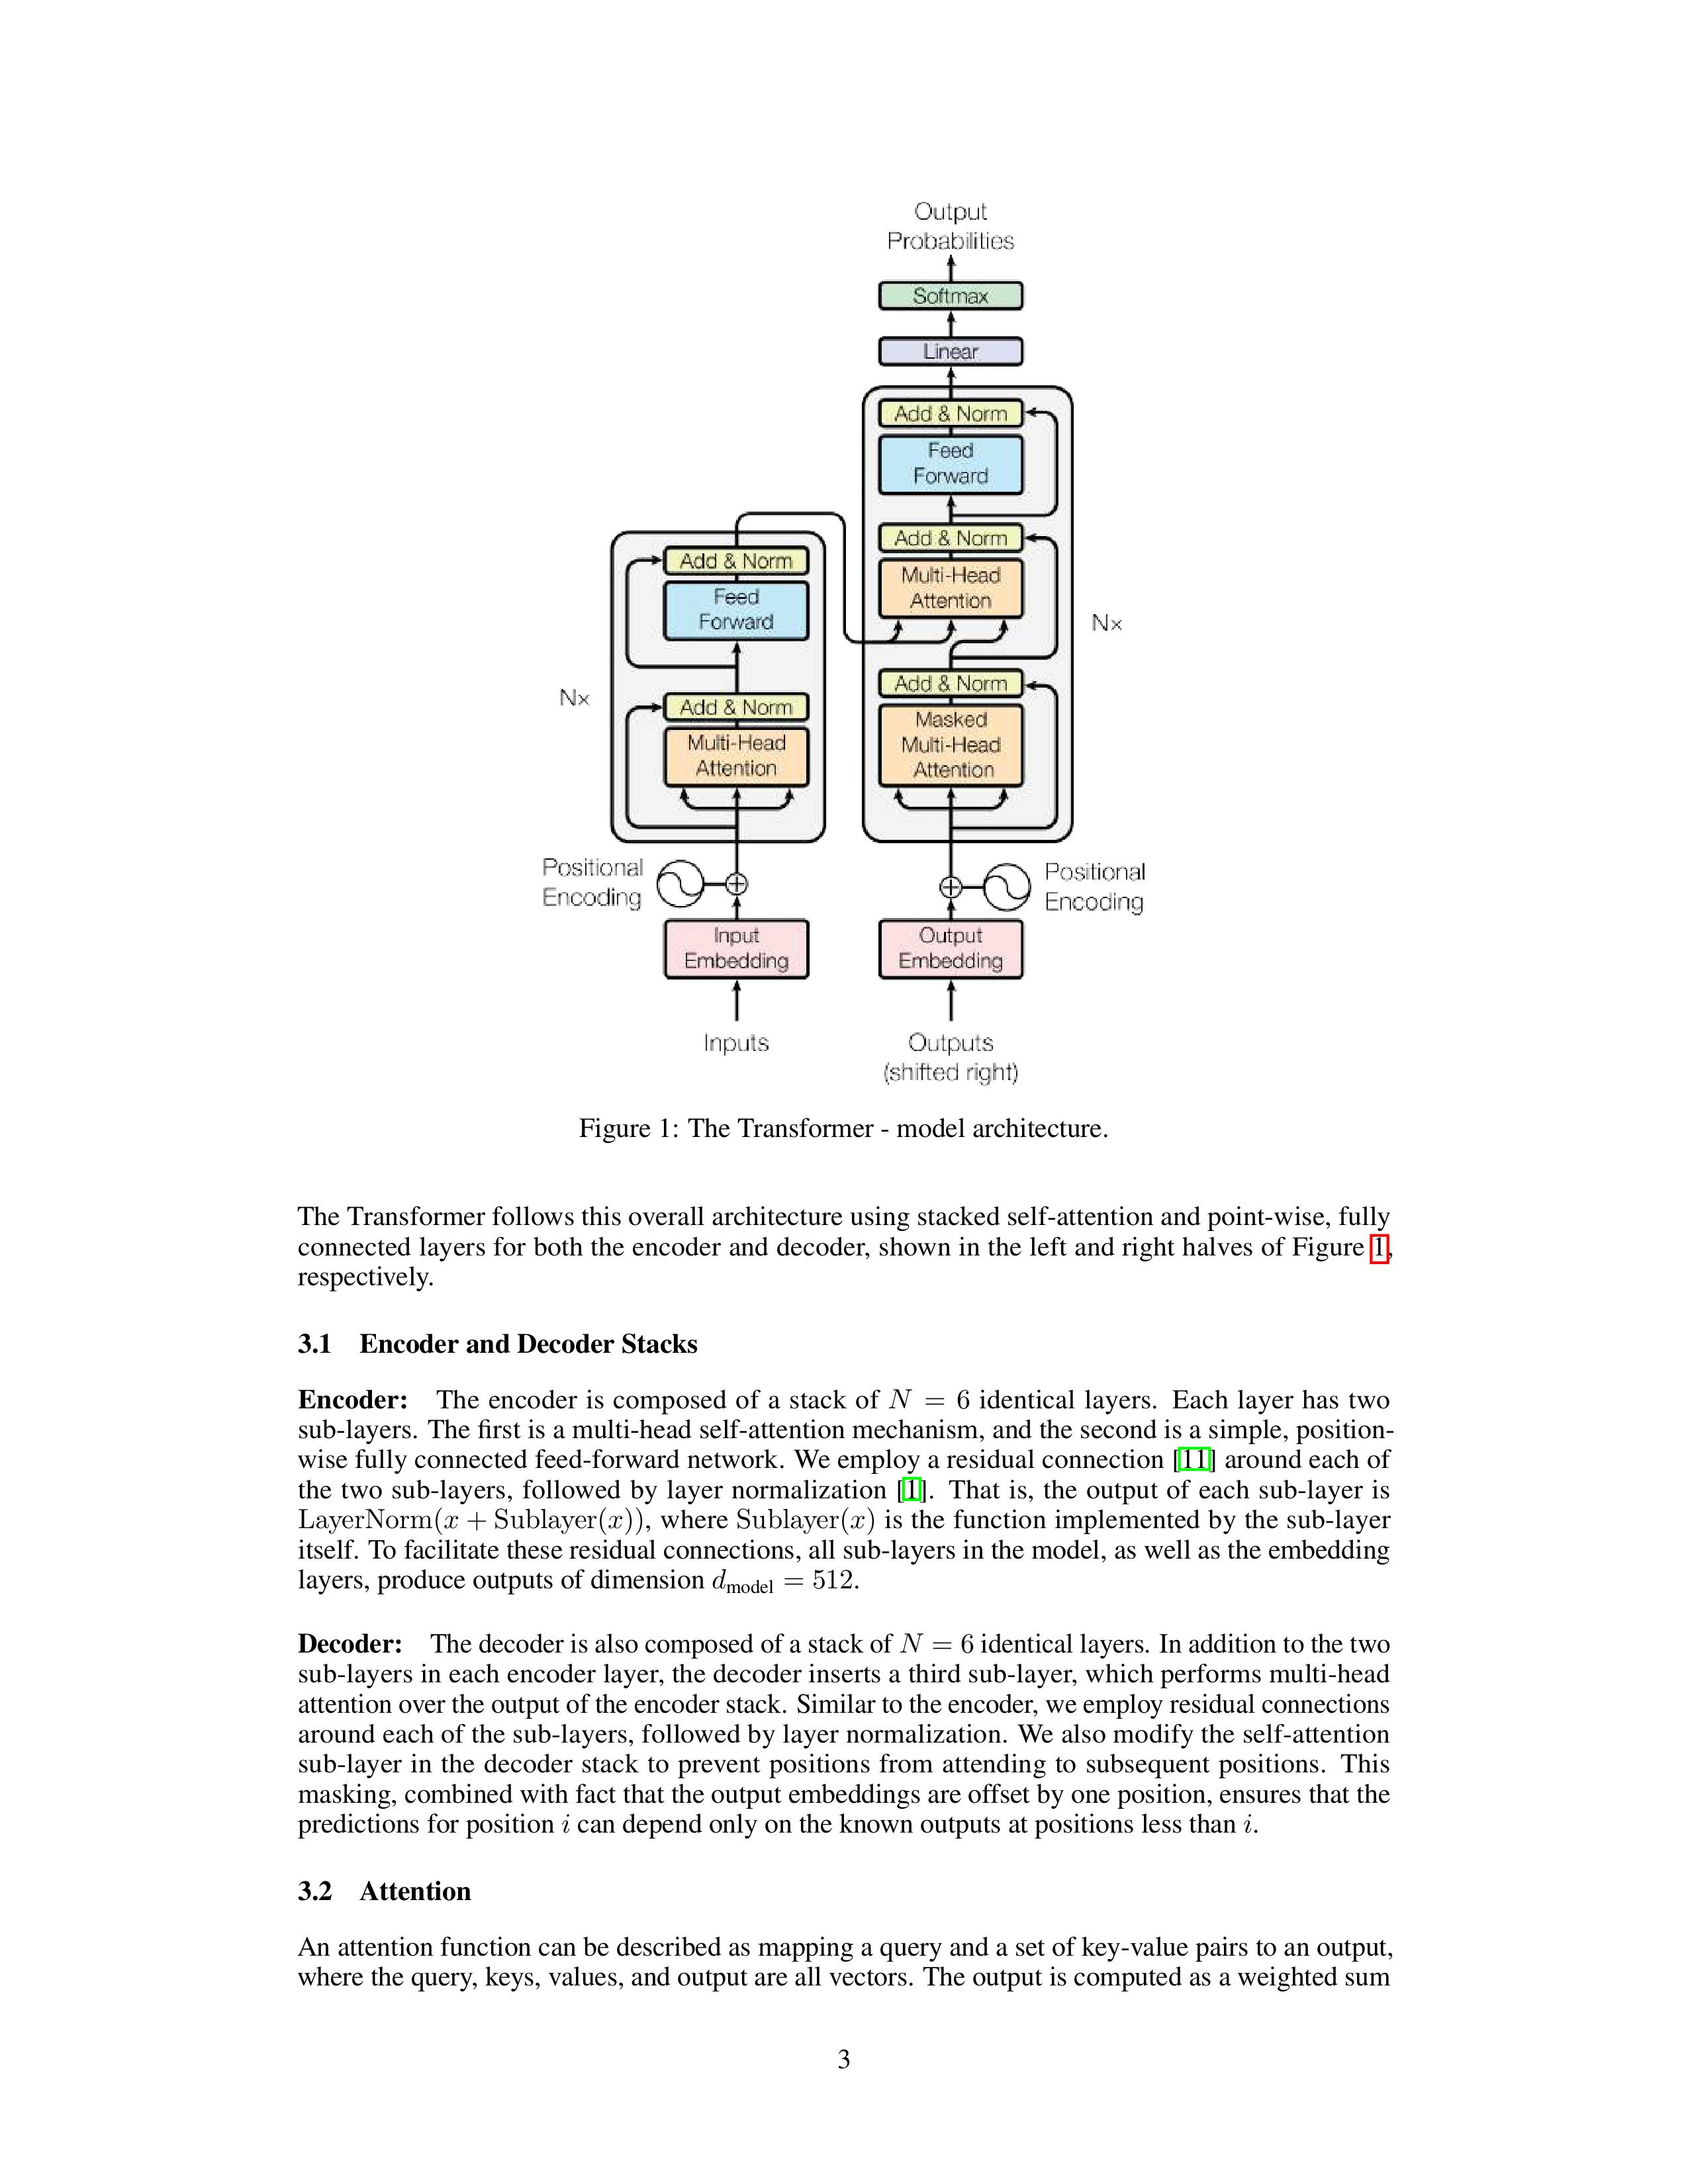

In [44]:
query = "what is the architecture of the transformer neural network?"
results = search_multimodal(query, vector_index, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))

...and another example:


🔍 Embedding query: 'a kitten with a robot'
✅ Query embedded successfully
---------------------------- Results for query = a kitten with a robot ----------------------------
  Similarity 0.814
----------------------------------------------------------------------------------------------------
  Filename images/image_1.jpeg
----------------------------------------------------------------------------------------------------
  Description `This image features a striking juxtaposition of a futuristic, menacing robot and an adorable, curious kitten in an industrial setting.

**Objects:**

1.  **Robot:** Occupying the right and center-right of the frame, a large, powerful, humanoid robot is depicted from the chest up.
    *   **Head/Helmet:** The robot's head is designed like a sleek, dark metallic helmet, featuring intricate circuit board patterns or etched lines across its surface, giving it a high-tech, integrated look.
    *   **Eyes:** The most prominent feature of the robot's face are 

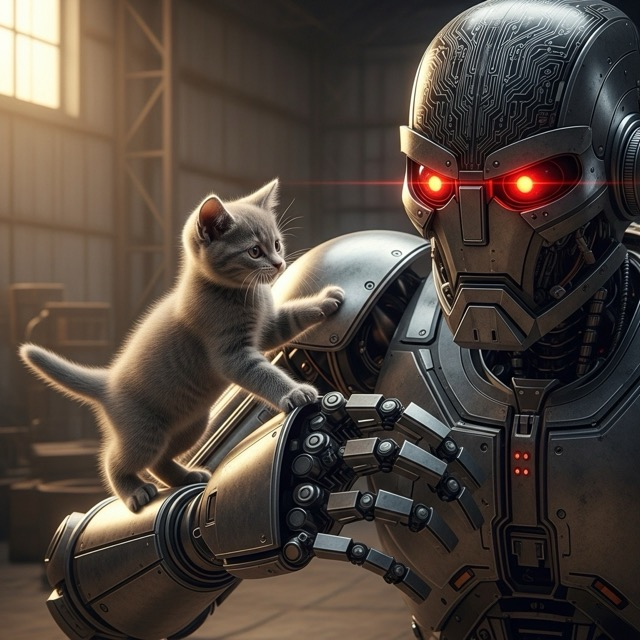

In [45]:
query = "a kitten with a robot"
results = search_multimodal(query, vector_index, top_k=1)

if not results:
    pretty_print.wrapped("❌ No results found", title="❌")
else:
    result = results[0]

    pretty_print.wrapped(
        [
            f"Similarity {result['similarity']:.3f}",
            f"Filename {result['filename']}",
            f"Description `{result['description'][:1000]}...`",
        ],
        title=f"Results for query = {query}",
    )
    display_image(Path(result["filename"]))

## 4. Building multimodal AI agents

The last step is to hook our RAG `search_multimodal` function to a ReAct agent to create an agentic RAG system.

First, we define the `multimodal_search_tool` using LangGraph:

In [46]:
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent


@tool
def multimodal_search_tool(query: str) -> dict[str, Any]:
    """
    Search through a collection of images and their text descriptions to find relevant content.

    This tool searches through a pre-indexed collection of image-text pairs using the query
    and returns the most relevant match. The search uses multimodal embeddings to find
    semantic matches between the query and the content.

    Args:
        query: Text query describing what to search for (e.g., "cat", "kitten with robot")

    Returns:
        A formatted string containing the search result with description and similarity score
    """

    pretty_print.wrapped(query, title="🔍 Tool executing search for:")

    results = search_multimodal(query, vector_index, top_k=1)

    if not results:
        return {"role": "tool_result", "content": "No relevant content found for your query."}
    else:
        pretty_print.wrapped(str(results[0]["filename"]), title="🔍 Found results:")
    result = results[0]

    content = [
        {
            "type": "text",
            "text": f"Image description: {result['description']}",
        },
        types.Part.from_bytes(
            data=result["content"],
            mime_type="image/jpeg",
        ),
    ]

    return {
        "role": "tool_result",
        "content": content,
    }

Next, we create a ReAct agent using LangGraph's `create_react_agent` function and the RAG tool defined above:

In [47]:
def build_react_agent() -> Any:
    """
    Build a ReAct agent with multimodal search capabilities.

    This function creates a LangGraph ReAct agent that can search through images
    and text using the multimodal_search_tool. The agent uses Gemini 2.5 Pro
    for reasoning and tool execution.

    Returns:
        Any: A LangGraph ReAct agent instance configured with multimodal search tools
    """

    tools = [multimodal_search_tool]

    system_prompt = """You are a helpful AI assistant that can search through images and text to answer questions.
    
    When asked about visual content like animals, objects, or scenes:
    1. Use the multimodal_search_tool to find relevant images and descriptions
    2. Carefully analyze the image or image descriptions from the search results
    3. Look for specific details like colors, features, objects, or characteristics
    4. Provide a clear, direct answer based on the search results
    5. If you can't find the specific information requested, be honest about limitations
    
    Pay special attention to:
    - Colors and visual characteristics
    - Animal features and breeds
    - Objects and their properties
    - Scene descriptions and context
    
    Always search first using your tools before attempting to answer questions about specific images or visual content.
    """

    agent = create_react_agent(
        model=ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.1),
        tools=tools,
        prompt=system_prompt,
    )

    return agent


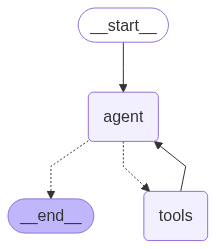

In [48]:
react_agent = build_react_agent()
react_agent

Now, let's test it and make the ReAct agent find the color of our kitten from the indexed dataset:

In [49]:
try:
    test_question = "what color is my kitten?"
    pretty_print.wrapped(test_question, title="🧪 Asking question:")

    response = react_agent.invoke(input={"messages": test_question})
    messages = response.get("messages", [])
    if messages:
        final_message = messages[-1].content
    else:
        final_message = "No response from the agent"
    pretty_print.wrapped(final_message, title="🤖 Agent response")
except Exception as e:
    print(f"❌ Error in ReAct agent: {e}")

---------------------------------------- 🧪 Asking question: ----------------------------------------
  what color is my kitten?
----------------------------------------------------------------------------------------------------
----------------------------------- 🔍 Tool executing search for: -----------------------------------
  my kitten
----------------------------------------------------------------------------------------------------

🔍 Embedding query: 'my kitten'
✅ Query embedded successfully
----------------------------------------- 🔍 Found results: -----------------------------------------
  images/image_1.jpeg
----------------------------------------------------------------------------------------------------
----------------------------------------- 🤖 Agent response -----------------------------------------
  Based on the image, your kitten is a gray tabby. It has soft, short gray fur with darker tabby stripe patterns.
--------------------------------------------------------

Based on the image from the previous section (the one with the kitten and robot), the answer is correct.